In [1]:

import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import optuna
import mlflow
from sklearn.model_selection import GridSearchCV
from pmdarima.arima import auto_arima



In [3]:

# # Configure API key authorization: ApiKeyAuth
# configuration = swagger_client.Configuration()
# configuration.api_key['key'] = 'YOUR_API_KEY'
# # Uncomment below to setup prefix (e.g. Bearer) for API key, if needed
# # configuration.api_key_prefix['key'] = 'Bearer'
# 
# # create an instance of the API class
# api_instance = swagger_client.APIsApi(swagger_client.ApiClient(configuration))
# q = 'Moscow' # Указываем название города Москва
# dt = '2024-04-18' # Указываем сегодняшнюю дату
# lang = 'ru' # Язык ответа - русский
# 
# try:
#     # Получаем текущую погоду
#     api_response = api_instance.current_weather(q, lang=lang)
#     pprint(api_response)
# except ApiException as e:
#     print("Exception when calling APIsApi->current_weather: %s\n" % e)

In [6]:
from weatherapi import WeatherPoint

# Подставьте свой ключ API погоды
key = "ae03964b347b4881afe205155242404"

# Широта и долгота для Москвы
latitude = 55.7558
longitude = 37.6176

# Инициализация объекта WeatherPoint
point = WeatherPoint(latitude, longitude)

# Установка ключа для доступа к данным
point.set_key(key)

# Получение текущей погоды
point.get_current_weather()

# Доступ к конкретным данным о погоде
temperature_celsius = point.temp_c  # температура в градусах Цельсия
#wind_speed_kmh = point.wind_kmh  # скорость ветра в километрах в час
local_datetime = point.localtime  # локальное время запроса


In [7]:
temperature_celsius

12.0

In [8]:
local_datetime

'2024-04-25 23:56'

In [11]:
import requests

# Установка базового URL и ключа API
base_url = "http://api.weatherapi.com/v1"
api_key = "ae03964b347b4881afe205155242404"  # Замените YOUR_API_KEY на ваш ключ API

# Параметры запроса
params = {
    "key": api_key,
    "q": "Moscow"  # Название города, для которого мы хотим получить погоду
}

# Формирование запроса
response = requests.get(f"{base_url}/current.json", params=params)

# Проверка успешности запроса
if response.status_code == 200:
    # Получение данных о погоде из ответа
    weather_data = response.json()

    # Извлечение интересующих нас данных о погоде
    temperature_celsius = weather_data['current']['temp_c']  # Температура в градусах Цельсия
    wind_speed_kmh = weather_data['current']['wind_kph']  # Скорость ветра в километрах в час
    local_datetime = weather_data['location']['localtime']  # Локальное время запроса

    # Вывод данных о погоде
    print(f"Текущая температура в Москве: {temperature_celsius}°C")
    print(f"Скорость ветра в Москве: {wind_speed_kmh} км/ч")
    print(f"Локальное время: {local_datetime}")
else:
    print("Ошибка при выполнении запроса:")
    print(response.text)


Текущая температура в Москве: 12.0°C
Скорость ветра в Москве: 4.0 км/ч
Локальное время: 2024-04-26 0:24


In [57]:
response.json()


{'location': {'name': 'Moscow',
  'region': 'Moscow City',
  'country': 'Russia',
  'lat': 55.75,
  'lon': 37.62,
  'tz_id': 'Europe/Moscow',
  'localtime_epoch': 1714080261,
  'localtime': '2024-04-26 0:24'},
 'current': {'last_updated_epoch': 1714079700,
  'last_updated': '2024-04-26 00:15',
  'temp_c': 12.0,
  'temp_f': 53.6,
  'is_day': 0,
  'condition': {'text': 'Clear',
   'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png',
   'code': 1000},
  'wind_mph': 2.5,
  'wind_kph': 4.0,
  'wind_degree': 330,
  'wind_dir': 'NNW',
  'pressure_mb': 1010.0,
  'pressure_in': 29.83,
  'precip_mm': 0.0,
  'precip_in': 0.0,
  'humidity': 77,
  'cloud': 0,
  'feelslike_c': 11.6,
  'feelslike_f': 52.8,
  'vis_km': 10.0,
  'vis_miles': 6.0,
  'uv': 1.0,
  'gust_mph': 8.3,
  'gust_kph': 13.3}}

In [58]:
api_response = response.json()
new_row = pd.DataFrame.from_dict({
    'Location': [api_response['location']['name']],
    'Region': [api_response['location']['region']],
    'Country': [api_response['location']['country']],
    'Latitude': [api_response['location']['lat']],
    'Longitude': [api_response['location']['lon']],
    'Localtime': [api_response['location']['localtime']],
    'Temperature_C': [api_response['current']['temp_c']],
    'Temperature_F': [api_response['current']['temp_f']],
    'Wind_Speed_kph': [api_response['current']['wind_kph']],
    'Wind_Direction': [api_response['current']['wind_dir']],
    'Pressure_mb': [api_response['current']['pressure_mb']],
    'Humidity': [api_response['current']['humidity']],
    'Cloud': [api_response['current']['cloud']],
    'FeelsLike_C': [api_response['current']['feelslike_c']],
    'FeelsLike_F': [api_response['current']['feelslike_f']],
    'Visibility_km': [api_response['current']['vis_km']],
    'UV_Index': [api_response['current']['uv']]
})

In [59]:
new_row

,Location,Region,Country,Latitude,Longitude,Localtime,Temperature_C,Temperature_F,Wind_Speed_kph,Wind_Direction,Pressure_mb,Humidity,Cloud,FeelsLike_C,FeelsLike_F,Visibility_km,UV_Index
0,Moscow,Moscow City,Russia,55.75,37.62,2024-04-26 0:24,12.0,53.6,4.0,NNW,1010.0,77,0,11.6,52.8,10.0,1.0


In [61]:
data_raw = pd.read_excel('data/archive.xls')
data_raw.head()

,Local time in Moscow,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,25.04.2024 21:00,14.9,744.0,757.3,0.9,69.0,"Calm, no wind",0.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus fibratus, sometimes uncinus, not progre...",20,9.2,No precipitation,12.0,NaN,NaN,NaN,NaN
1,25.04.2024 18:00,20.6,743.1,756.1,0.2,46.0,Wind blowing from the south-southeast,1.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus fibratus, sometimes uncinus, not progre...",20,8.6,No precipitation,12.0,NaN,NaN,NaN,NaN
2,25.04.2024 15:00,20.2,742.9,755.8,0.1,53.0,Wind blowing from the south-east,2.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus fibratus, sometimes uncinus, not progre...",20,10.2,NaN,NaN,NaN,NaN,NaN,NaN
3,25.04.2024 12:00,18.1,742.8,755.8,0.1,55.0,Wind blowing from the south-southeast,2.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.",Cirrostratus covering the whole sky.,19,8.9,NaN,NaN,NaN,NaN,NaN,NaN
4,25.04.2024 09:00,14.1,742.7,756.1,-1.1,58.0,Wind blowing from the south-southeast,3.0,NaN,NaN,...,"No Altocumulus, Altostratus or Nimbostratus.","Cirrus (often in bands) and Cirrostratus, or C...",20,5.8,0.1,12.0,Surface of ground wet (standing water in small...,8.0,NaN,NaN


In [77]:
data = data_raw[['Local time in Moscow', 'T']]
data.dropna(inplace=True)

C:\Users\Peter\AppData\Local\Temp\ipykernel_31580\3518725495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


C:\Users\Peter\AppData\Local\Temp\ipykernel_31580\4015242811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')


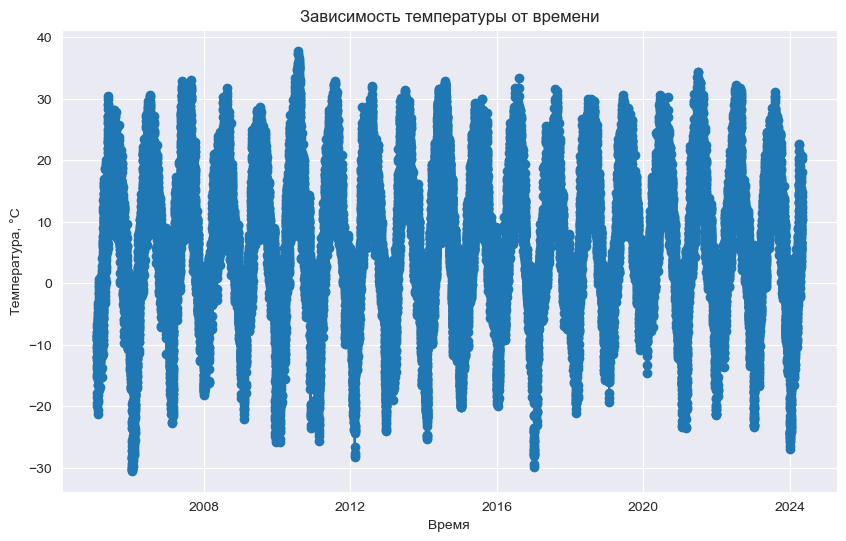

In [63]:

import matplotlib.pyplot as plt



# Преобразование столбца 'Local time in Moscow' в формат datetime
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')

# Создание графика
plt.figure(figsize=(10, 6))
plt.plot(data['Local time in Moscow'], data['T'], marker='o', linestyle='-')

# Настройка осей и заголовка графика
plt.xlabel('Время')
plt.ylabel('Температура, °C')
plt.title('Зависимость температуры от времени')

# Вывод графика
plt.grid(True)
plt.show()


In [68]:
data.index

DatetimeIndex(['2024-04-25 21:00:00', '2024-04-25 18:00:00',
               '2024-04-25 15:00:00', '2024-04-25 12:00:00',
               '2024-04-25 09:00:00', '2024-04-25 06:00:00',
               '2024-04-25 03:00:00', '2024-04-25 00:00:00',
               '2024-04-24 21:00:00', '2024-04-24 18:00:00',
               ...
               '2005-02-02 06:00:00', '2005-02-02 03:00:00',
               '2005-02-02 00:00:00', '2005-02-01 21:00:00',
               '2005-02-01 18:00:00', '2005-02-01 15:00:00',
               '2005-02-01 12:00:00', '2005-02-01 09:00:00',
               '2005-02-01 06:00:00', '2005-02-01 03:00:00'],
              dtype='datetime64[ns]', name='Local time in Moscow', length=65503, freq=None)

In [4]:
data = pd.read_excel('data/archive.xls')


In [5]:
# Преобразование столбца 'Local time in Moscow' в формат datetime и установка его в качестве индекса
data.fillna(data.mean(), inplace=True)  # Замена NaN на среднее значение
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)

# Выбор столбца с температурой для прогнозирования
temperature = data['T']

# Разделение данных на тренировочный и тестовый наборы по времени
train = data.loc[data.index < '2023-01-01']
test = data.loc[data.index >= '2023-01-01']
endog_column = 'T'  # Replace 'T' with the actual column name representing the target variable
endog_train = train[endog_column]
endog_test = test[endog_column]

# Создание и обучение модели SARIMA с использованием GridSearchCV
model = SARIMAX(endog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_search.fit(endog_train)

# Получение наилучших гиперпараметров
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Создание и обучение модели SARIMA с наилучшими найденными параметрами
best_model = SARIMAX(endog_train, order=best_params['order'], seasonal_order=best_params['seasonal_order'])
best_model_fit = best_model.fit(disp=False)

# Прогнозирование на тестовом наборе с использованием наилучшей модели
forecast = best_model_fit.forecast(steps=len(endog_test))

# Оценка производительности наилучшей модели
mse = mean_squared_error(endog_test, forecast)
print('Mean Squared Error (Best Model):', mse)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(endog_test.index, endog_test, label='Фактическая температура')
plt.plot(endog_test.index, forecast, color='red', label='Прогноз температуры')
plt.title('Прогноз температуры с помощью SARIMA (с оптимизацией гиперпараметров)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()

TypeError: can only concatenate str (not "int") to str

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
data = pd.read_excel('data/archive.xls')
data['T'].dropna(inplace=True)


# Preprocess data
data['Local time in Moscow'] = pd.to_datetime(data['Local time in Moscow'], format='%d.%m.%Y %H:%M')
data.set_index('Local time in Moscow', inplace=True)

# # Select target variable
# endog_column = 'T'
# endog = data[endog_column]

# Split data into train and test sets
# train = endog.loc[endog.index < '2023-01-01']
# test = endog.loc[endog.index >= '2023-01-01']

# 
# # # Define SARIMAX model parameters (order and seasonal_order)
# # order = (1, 2, 1)
# # seasonal_order = (1, 1, 1, 12)
# # Подбор оптимальной SARIMA модели
# model = auto_arima(train, seasonal=True, m=12)
# 
# # Прогнозирование с использованием SARIMA модели
# forecast = model.predict(n_periods=len(test))
# 
# # Оценка производительности модели
# mse = mean_squared_error(test, forecast)
# print('Mean Squared Error:', mse)
# 
# # Визуализация результатов
# plt.figure(figsize=(12, 6))
# plt.plot(test.index, test, label='Фактическая температура')
# plt.plot(test.index, forecast, color='red', label='Прогноз температуры')
# plt.title('Прогноз температуры с использованием SARIMA (с автоподбором гиперпараметров)')
# plt.xlabel('Дата')
# plt.ylabel('Температура')
# plt.legend()
# plt.show()


In [28]:
data.columns

Index(['T', 'Po', 'P', 'Pa', 'U', 'DD', 'Ff', 'ff10', 'ff3', 'N', 'WW', 'W1',
       'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'VV', 'Td', 'RRR', 'tR',
       'E', 'Tg', 'E'', 'sss'],
      dtype='object')

In [29]:
data.drop(['Po', 'P', 'Pa', 'U', 'DD', 'Ff', 'ff10', 'ff3', 'N', 'WW', 'W1',
           'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'VV', 'Td', 'RRR',
           'tR', 'E', 'Tg', 'E','sss'], inplace=True)
data

KeyError: "['Po', 'P', 'Pa', 'U', 'DD', 'Ff', 'ff10', 'ff3', 'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'VV', 'Td', 'RRR', 'tR', 'E', 'Tg', 'E', 'sss'] not found in axis"

In [54]:

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                52408
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -99960.167
Date:                            Fri, 26 Apr 2024   AIC                         199930.334
Time:                                    01:57:09   BIC                         199974.666
Sample:                                         0   HQIC                        199944.190
                                          - 52408                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1503      0.015     -9.773      0.000      -0.180      -0.120
ma.L1          0.3366      0.015   

In [ ]:
f